# 实验2：知识增益
- **知识增益（Knowledge Gain, KG）**：不使用context的语义熵减去使用context的语义熵


## 数据格式
`qwen-$dataset.pkl`

```
{
	"meta": {
		"model": "qwen",
		"dataset": "$dataset"
	},
	"data": [{
		"example": {
			"id": "id1",
			"question": "q1",
			"context": "c1",
			"answers": ["a1"]
		},
		"golden": {
			"greedy_response": "gready_text",
			"tbg_emb": Tensor(),
			"slt_emb": Tensor(),
			"sample_responses": ["response1","response2"],
			"cluster_ids": [0,1],
			"entropy": 1.5,
			"accuracy_qwen": 1.0,
			"accuracy_gpt": 1.0,
		},
		"irrelevant": {},
		"without": {},
	}]
}

```

In [1]:
%load_ext autoreload
%autoreload 2

import json
import warnings
import os
import pickle
from tqdm import tqdm
import torch
from collections import defaultdict, Counter
import argparse
from core.models.entailment import EntailmentDeberta
from core.data.data_utils import load_ds_from_json
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from core.computation.uncertainty_measure import cluster_assignment_entropy
import seaborn as sns

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
rng = np.random.default_rng(42)


def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            it = {}
            it['text'] = r['text']
            it['slt_emb'] = r['hidden_states']['sec_last_token_embedding']
            it['tbg_emb'] = r['hidden_states']['last_tok_bef_gen_embedding']
            responses.append(it)
    return responses

def load_greedy_response(generation_file_path):
    responses = load_responses(generation_file_path)
    assert len(responses) <= 1, f"More than one response found in {generation_file_path}."
    return responses[0] if len(responses) == 1 else None

def load_sample_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            responses.append(r['text'])
    return responses

def load_qwen_accuracy(eval_file_path):
    accuracy = []
    if os.path.exists(eval_file_path):
        res = load_pickle_file(eval_file_path)
        accuracy = res.get('qwen_scores', [])
    return accuracy[0] if len(accuracy) == 1 else None

def load_cluster_ids(clustered_file_path):
    cluster_ids = []
    if os.path.exists(clustered_file_path):
        res = load_pickle_file(clustered_file_path)
        cluster_ids = res.get('cluster_ids', [])
    return cluster_ids

# 计算语义熵
def compute_entropy(cluster_ids):
    if len(cluster_ids) == 0:
        return -1
    return cluster_assignment_entropy(cluster_ids)

# 检查数据是否完整
def check_item(item):
    for context_type in ["golden", "irrelevant", "without"]:
        if context_type not in item:
            return False
        context = item[context_type]
        if context.get("tbg_emb", None) is None:
            return False
        if context.get("slt_emb", None) is None:
            return False
        if context.get("greedy_response", None) is None:
            return False
        if context.get("sample_responses", None) is None:
            return False
        if context.get("cluster_ids", None) is None:
            return False
        if context.get("entropy", None) is None:
            return False
        if context.get("accuracy_qwen", None) is None:
            return False
        if len(context["sample_responses"]) != len(context["cluster_ids"]):
            return False
    
    return True

def load_data(dataset_name, model_name='qwen'):
    all_data = load_pickle_file(f"output/data/{model_name}-{dataset_name}.pkl")
    data = []
    for item in all_data["data"]:
        if check_item(item):
            data.append(item)
    return data

squad: 1998


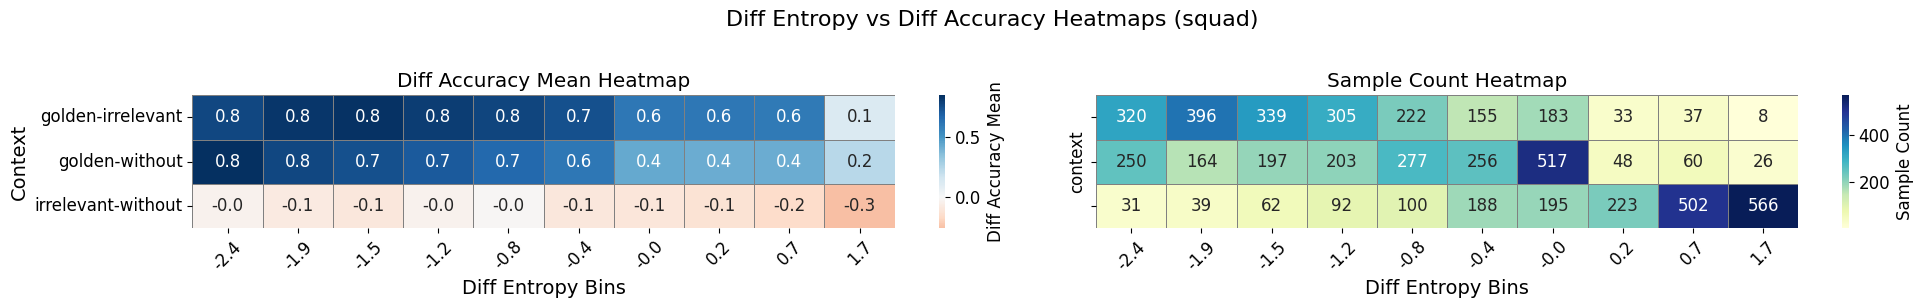

triviaqa: 1997


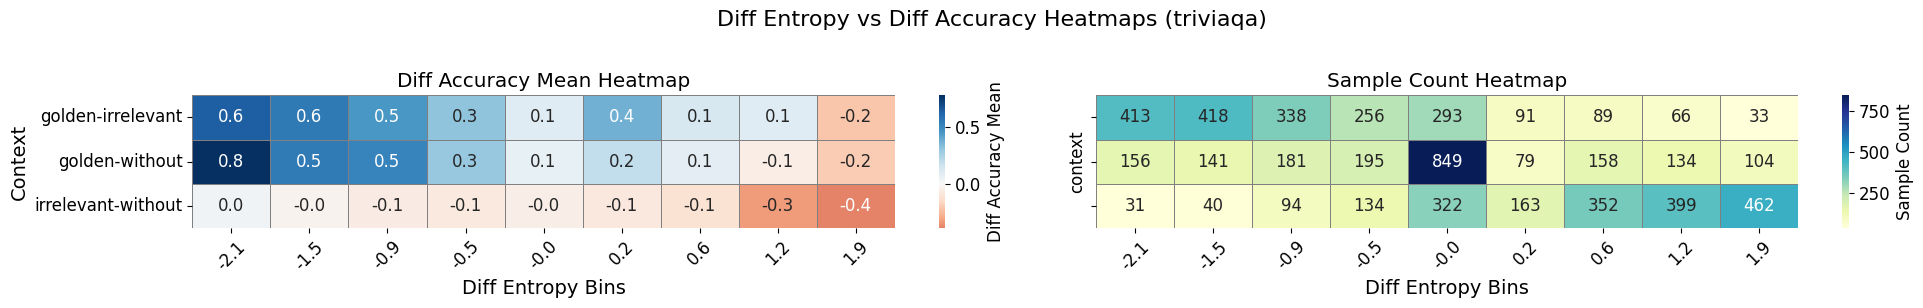

bioasq: 1997


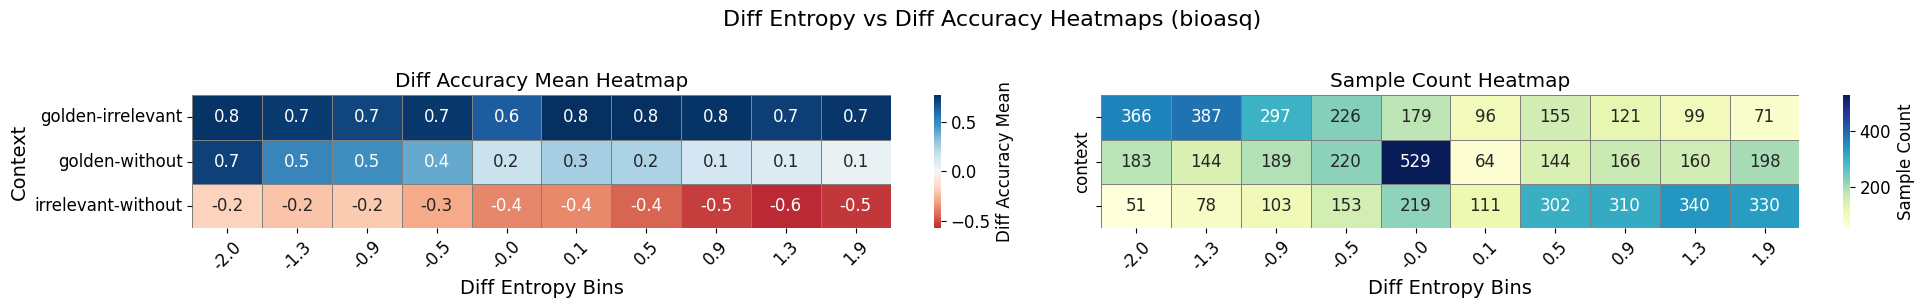

all: 5992


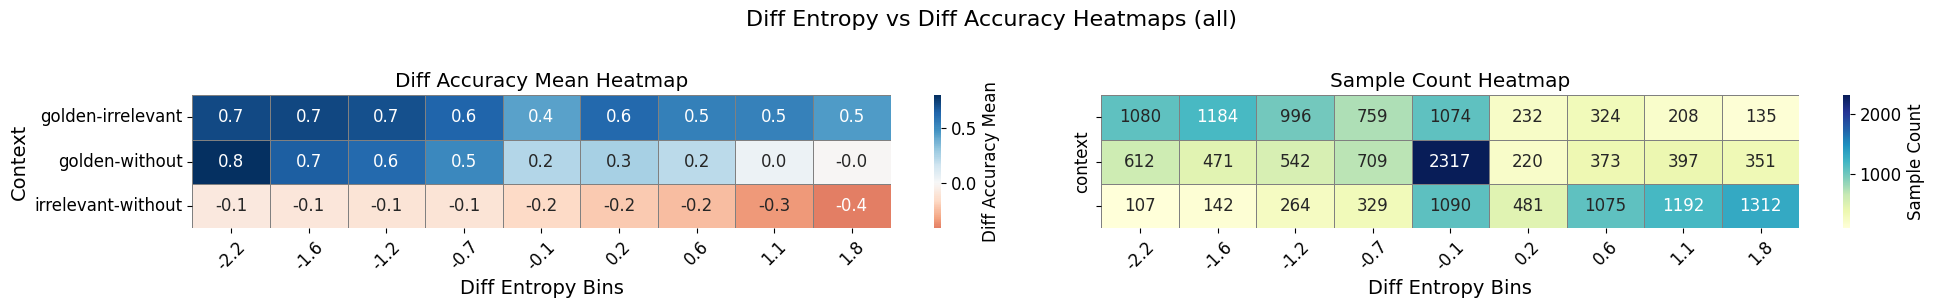

CPU times: user 5.94 s, sys: 2.12 s, total: 8.06 s
Wall time: 8.05 s


In [4]:
def plot_diff_entropy_vs_diff_accuracy_dual_heatmap(data, subtitle=None):
    """
    绘制 Diff Entropy vs Diff Accuracy 的双热力图，分别显示均值和样本数量。
    
    参数:
    - data: 数据列表，包含 'golden', 'irrelevant', 'without' 三种上下文。
    - subtitle: 可选的子标题。
    """
    # 数据预处理（与之前相同）
    records = []
    for entry in data:
        golden = entry.get('golden', {})
        irrelevant = entry.get('irrelevant', {})
        without = entry.get('without', {})
        
        # 计算差异
        diff_entropy_golden_without = golden.get('entropy', np.nan) - without.get('entropy', np.nan)
        diff_accuracy_golden_without = golden.get('accuracy_qwen', np.nan) - without.get('accuracy_qwen', np.nan)
        
        diff_entropy_irrelevant_without = irrelevant.get('entropy', np.nan) - without.get('entropy', np.nan)
        diff_accuracy_irrelevant_without = irrelevant.get('accuracy_qwen', np.nan) - without.get('accuracy_qwen', np.nan)
        
        diff_entropy_golden_irrelevant = golden.get('entropy', np.nan) - irrelevant.get('entropy', np.nan)
        diff_accuracy_golden_irrelevant = golden.get('accuracy_qwen', np.nan) - irrelevant.get('accuracy_qwen', np.nan)
        
        # 添加记录
        records.extend([
            {
                'context': 'golden-without',
                'diff_entropy': diff_entropy_golden_without,
                'diff_accuracy': diff_accuracy_golden_without
            },
            {
                'context': 'irrelevant-without',
                'diff_entropy': diff_entropy_irrelevant_without,
                'diff_accuracy': diff_accuracy_irrelevant_without
            },
            {
                'context': 'golden-irrelevant',
                'diff_entropy': diff_entropy_golden_irrelevant,
                'diff_accuracy': diff_accuracy_golden_irrelevant
            }
        ])
    
    df = pd.DataFrame(records).dropna(subset=['diff_entropy', 'diff_accuracy'])

    # 分箱
    num_bins = 10
    df['diff_entropy_bin'] = pd.qcut(df['diff_entropy'], q=num_bins, duplicates='drop')

    # 计算每个箱的中心值，并保留一位小数
    bin_centers = df.groupby('diff_entropy_bin')['diff_entropy'].mean().round(1)

    # 计算每个上下文和每个箱的平均准确率差和样本数量
    grouped = df.groupby(['context', 'diff_entropy_bin']).agg(
        average_diff_accuracy=('diff_accuracy', 'mean'),
        sample_count=('diff_accuracy', 'count')
    ).reset_index()

    # 创建透视表
    pivot_accuracy = grouped.pivot(index='context', columns='diff_entropy_bin', values='average_diff_accuracy')
    pivot_count = grouped.pivot(index='context', columns='diff_entropy_bin', values='sample_count')

    # 定义颜色映射
    color_map = {
        'golden-without': 'gold',
        'irrelevant-without': 'silver',
        'golden-irrelevant': 'blue'
    }

    # 设置字体大小
    plt.rcParams.update({'font.size': 12})

    # 创建子图
    fig, axes = plt.subplots(1, 2, figsize=(20, 3), sharey=True)

    # 绘制均值热力图
    sns.heatmap(
        pivot_accuracy,
        annot=True,
        fmt=".1f",
        cmap='RdBu',
        center=0,
        cbar_kws={'label': 'Diff Accuracy Mean'},
        linewidths=.5,
        linecolor='gray',
        ax=axes[0]
    )
    axes[0].set_title('Diff Accuracy Mean Heatmap')

    # 绘制样本数量热力图
    sns.heatmap(
        pivot_count,
        annot=True,
        fmt='d',
        cmap='YlGnBu',
        cbar_kws={'label': 'Sample Count'},
        linewidths=.5,
        linecolor='gray',
        ax=axes[1]
    )
    axes[1].set_title('Sample Count Heatmap')

    # 设置标题
    title = 'Diff Entropy vs Diff Accuracy Heatmaps'
    if subtitle:
        title += f' ({subtitle})'
    plt.suptitle(title, fontsize=16, y=1.02)

    # 设置x轴刻度为保留一位小数
    for ax in axes:
        ax.set_xlabel('Diff Entropy Bins', fontsize=14)
        ax.set_xticklabels([f'{center:.1f}' for center in bin_centers], rotation=45)
    axes[0].set_ylabel('Context', fontsize=14)

    plt.tight_layout()
    plt.show()

def plot_dataset(data, dataset):
    print(f"{dataset}: {len(data)}")
    plot_diff_entropy_vs_diff_accuracy_dual_heatmap(data, dataset)

def plot_all():
    all_data = []
    for dataset in ["squad", "triviaqa", "bioasq"]:
        data = load_data(dataset)
        plot_dataset(data, dataset)
        all_data.extend(data)
    plot_dataset(all_data, "all")

%time plot_all()

squad: 1998 samples


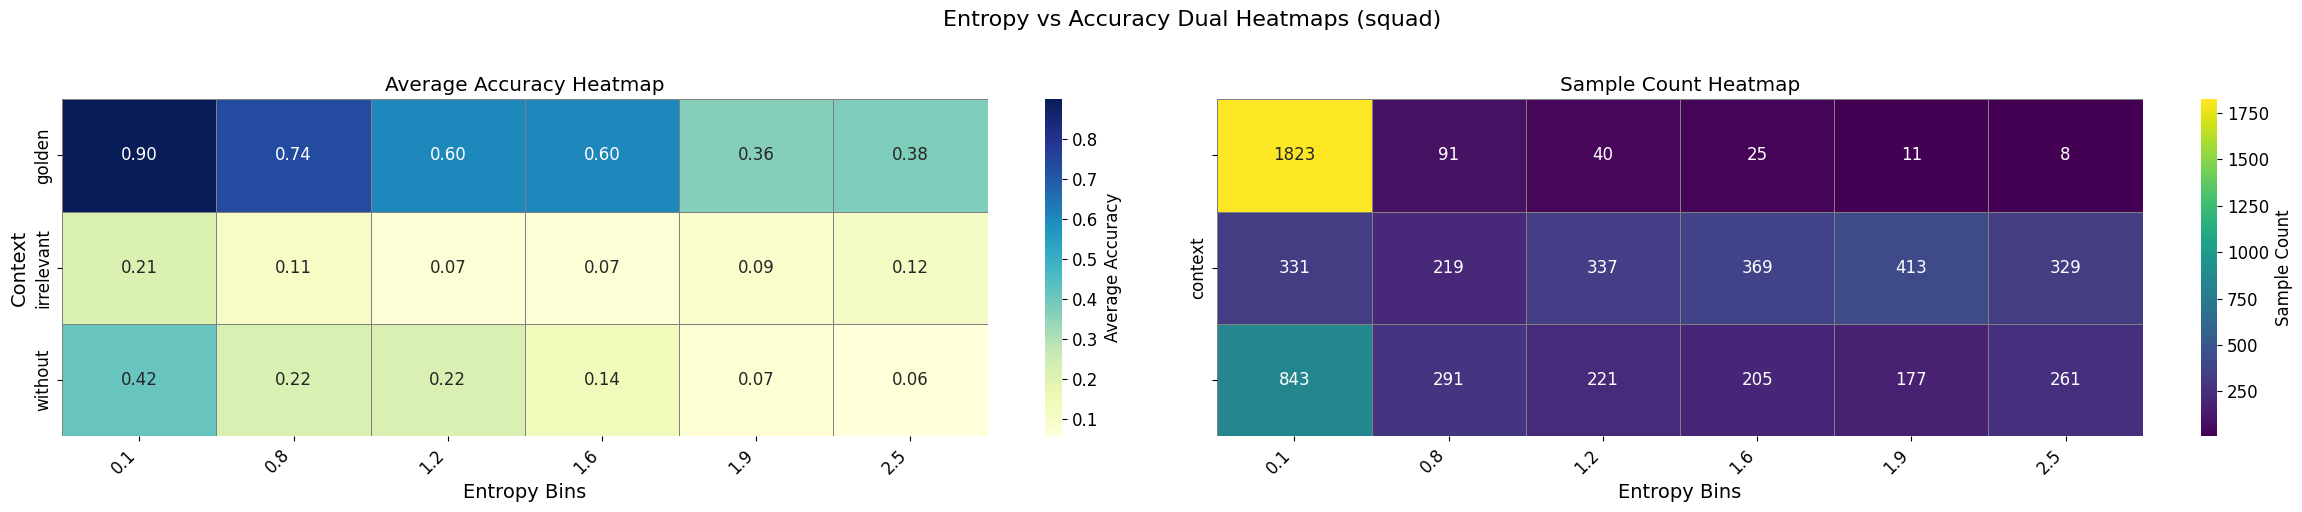

triviaqa: 1997 samples


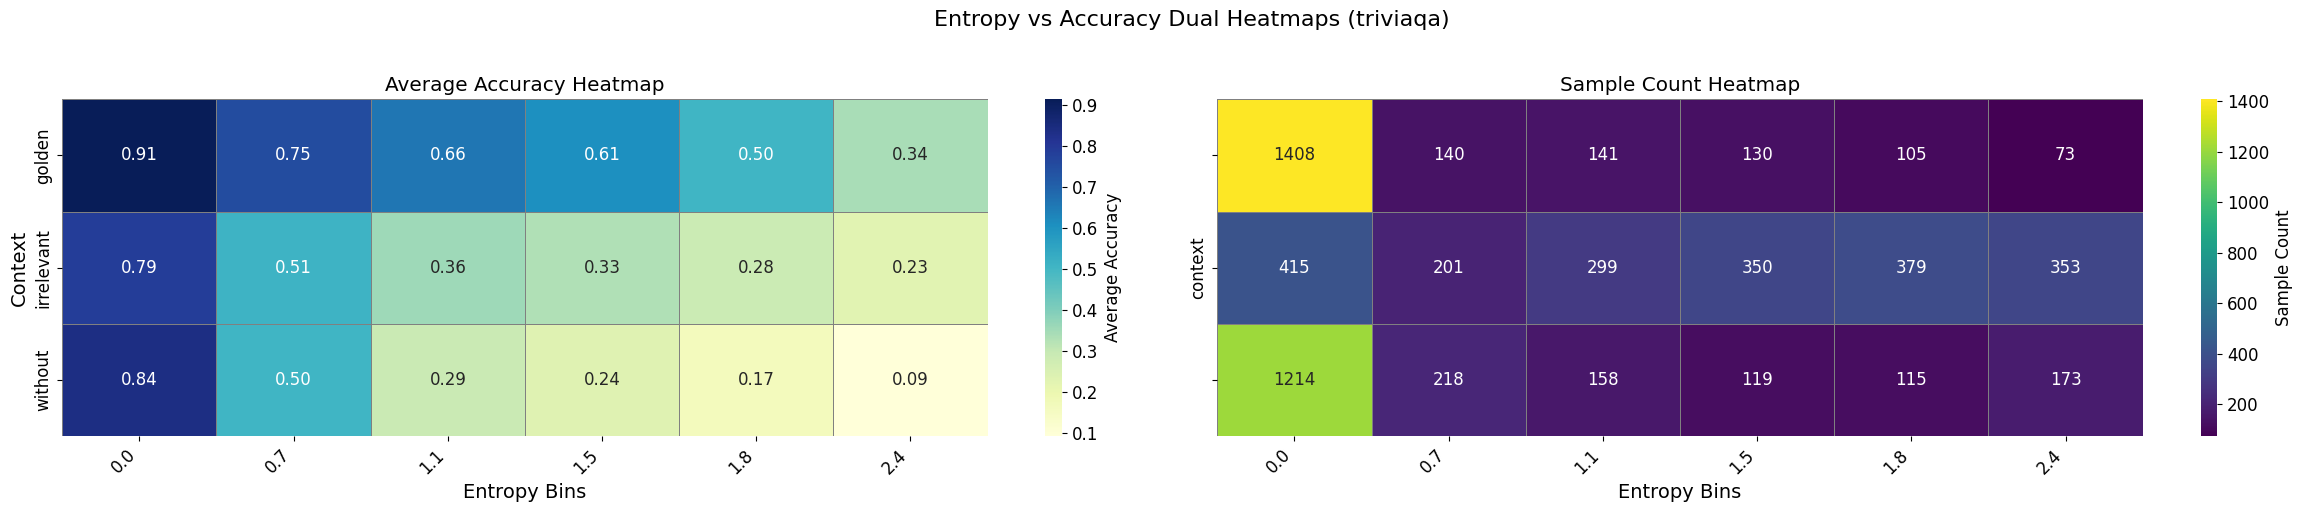

bioasq: 1997 samples


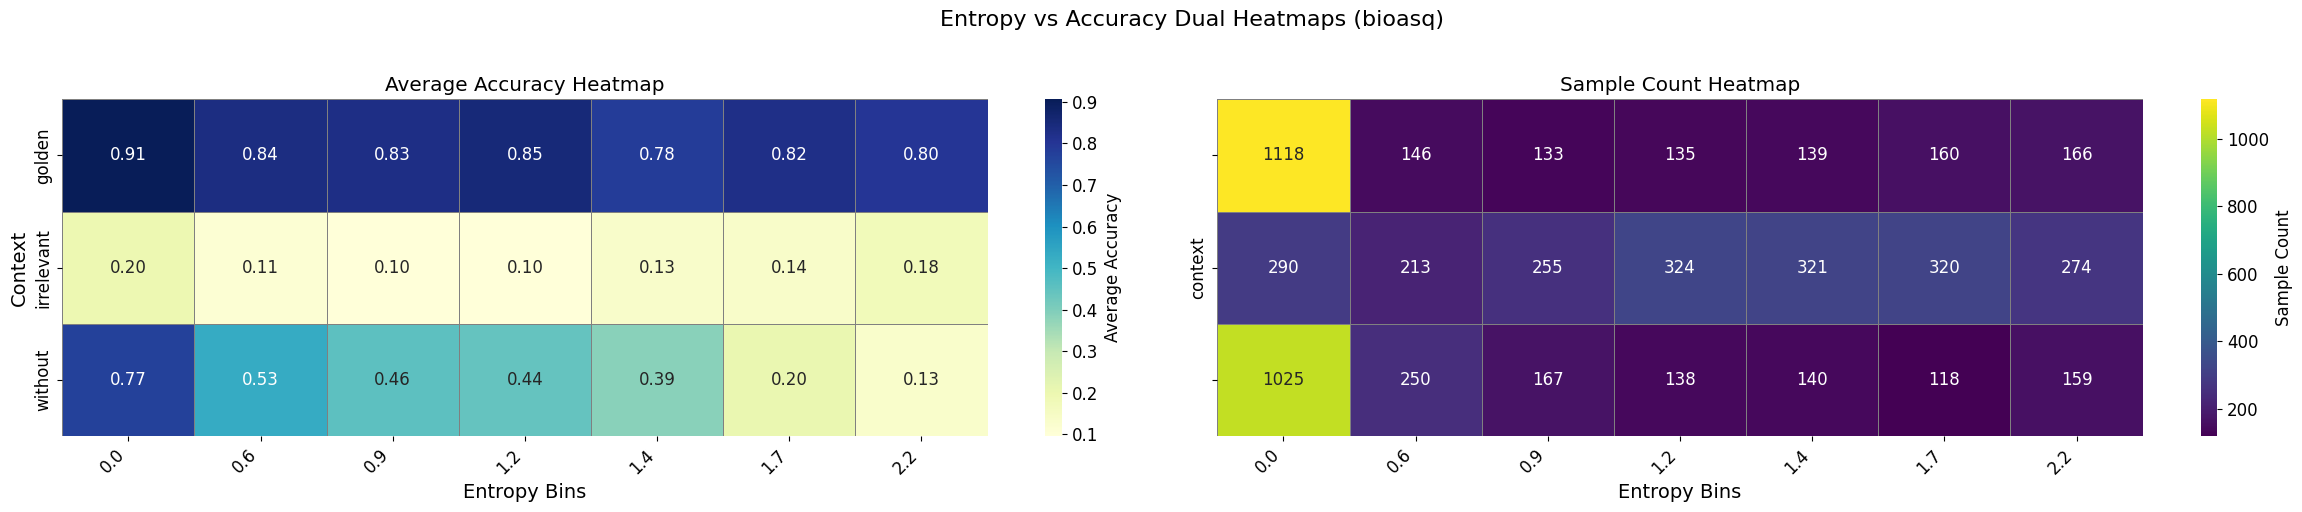

All Datasets: 5992 samples


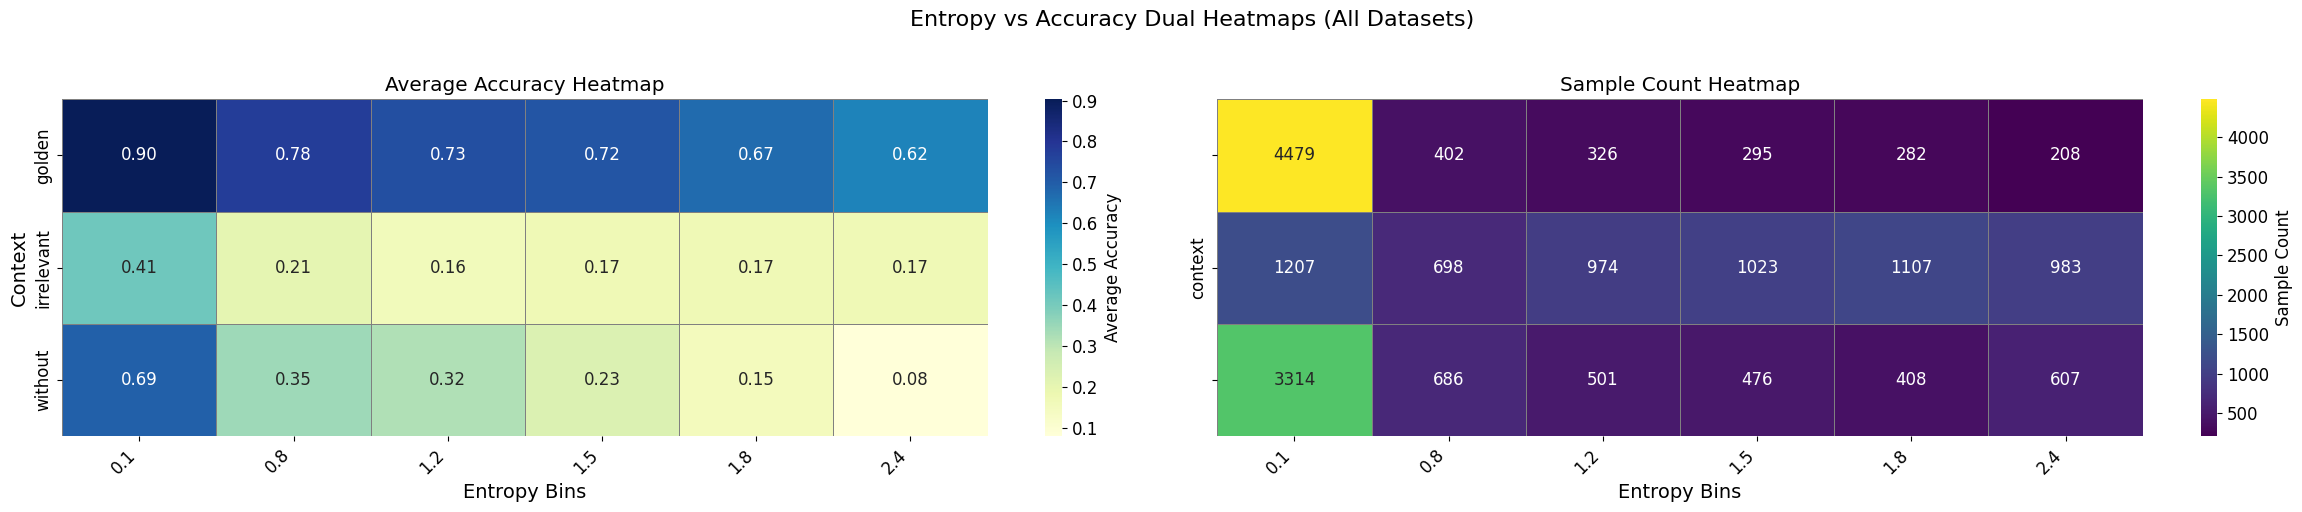

CPU times: user 6.02 s, sys: 2.04 s, total: 8.06 s
Wall time: 8.05 s


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_entropy_vs_accuracy_dual_heatmap(data, subtitle=None):
    """
    Plot dual heatmaps for Entropy vs Accuracy, showing both average accuracy and sample count.
    
    Parameters:
    - data: List of data entries, each containing 'golden', 'irrelevant', and 'without' contexts.
    - subtitle: Optional subtitle for the plot.
    """
    # Data Preprocessing
    records = []
    for entry in data:
        for context in ['golden', 'irrelevant', 'without']:
            context_data = entry.get(context, {})
            records.append({
                'context': context,
                'entropy': context_data.get('entropy', np.nan),
                'accuracy': context_data.get('accuracy_qwen', np.nan)
            })
    
    df = pd.DataFrame(records).dropna(subset=['entropy', 'accuracy'])
    
    # Binning
    num_bins = 10
    try:
        df['entropy_bin'] = pd.qcut(df['entropy'], q=num_bins, duplicates='drop')
    except ValueError as e:
        print(f"Error during binning: {e}")
        return
    
    # Aggregation: Calculate average accuracy and sample count for each context and entropy bin
    grouped = df.groupby(['context', 'entropy_bin']).agg(
        average_accuracy=('accuracy', 'mean'),
        sample_count=('accuracy', 'count')
    ).reset_index()
    
    # Create Pivot Tables for Heatmaps
    pivot_accuracy = grouped.pivot(index='context', columns='entropy_bin', values='average_accuracy')
    pivot_count = grouped.pivot(index='context', columns='entropy_bin', values='sample_count')
    
    # Calculate bin centers for labeling
    bin_centers = df.groupby('entropy_bin')['entropy'].mean().round(1)
    
    # Define color maps
    color_map_accuracy = 'YlGnBu'
    color_map_count = 'viridis'
    
    # Set font size
    plt.rcParams.update({'font.size': 12})
    
    # Create Subplots with figsize (24, 3)
    fig, axes = plt.subplots(1, 2, figsize=(24, 5), sharey=True)
    
    # Plot Average Accuracy Heatmap
    sns.heatmap(
        pivot_accuracy,
        annot=True,
        fmt=".2f",
        cmap=color_map_accuracy,
        cbar_kws={'label': 'Average Accuracy'},
        linewidths=.5,
        linecolor='gray',
        ax=axes[0]
    )
    axes[0].set_title('Average Accuracy Heatmap')
    
    # Plot Sample Count Heatmap
    sns.heatmap(
        pivot_count,
        annot=True,
        fmt='d',
        cmap=color_map_count,
        cbar_kws={'label': 'Sample Count'},
        linewidths=.5,
        linecolor='gray',
        ax=axes[1]
    )
    axes[1].set_title('Sample Count Heatmap')
    
    # Set Overall Title
    title = 'Entropy vs Accuracy Dual Heatmaps'
    if subtitle:
        title += f' ({subtitle})'
    plt.suptitle(title, fontsize=16, y=1.02)
    
    # Set X-axis Labels with Bin Centers
    for ax in axes:
        ax.set_xlabel('Entropy Bins', fontsize=14)
        ax.set_xticklabels([f'{center:.1f}' for center in bin_centers], rotation=45, ha='right')
    axes[0].set_ylabel('Context', fontsize=14)
    
    plt.tight_layout()
    plt.show()

def plot_dataset_dual(data, dataset):
    print(f"{dataset}: {len(data)} samples")
    plot_entropy_vs_accuracy_dual_heatmap(data, dataset)

def plot_all_dual():
    all_data = []
    for dataset in ["squad", "triviaqa", "bioasq"]:
        data = load_data(dataset)  # Ensure the load_data function is defined and returns the correct format
        plot_dataset_dual(data, dataset)
        all_data.extend(data)
    plot_dataset_dual(all_data, "All Datasets")

# Call the new dual heatmap plotting function
%time plot_all_dual()